In [1]:
import geopandas as gpd
import asf_search as asf
from shapely.geometry import shape
import pandas as pd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import numpy as np

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

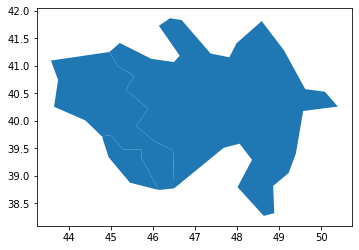

In [3]:
countries_with_missing_tiles = world[world.name.isin(['Azerbaijan', 'Armenia'])]
countries_with_missing_tiles.plot()

<ipython-input-4-2f722c0c232d>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry = countries_with_missing_tiles.geometry.buffer(.01).unary_union


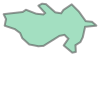

In [4]:
# .01 degree is about 1 km near the equator
geometry = countries_with_missing_tiles.geometry.buffer(.01).unary_union
geometry

In [5]:
results = asf.geo_search(intersectsWith=geometry.wkt,
                         processingLevel=[asf.PRODUCT_TYPE.GUNW_STD], 
                         maxResults=1_000_000)
results[0].geojson()

{'type': 'Feature',
 'geometry': {'coordinates': [[[45.753284, 42.097027],
    [48.82357513796966, 42.4951879864791],
    [49.165844, 40.878098],
    [46.17387604940508, 40.47939719330934],
    [45.753284, 42.097027]]],
  'type': 'Polygon'},
 'properties': {'beamModeType': 'slc',
  'browse': ['https://grfn-public-prod.asf.alaska.edu/S1-GUNW-A-R-101-tops-20220515_20210601-144611-00046E_00040N-PP-7bda-v2_0_5.png'],
  'bytes': '63857033',
  'centerLat': None,
  'centerLon': None,
  'faradayRotation': None,
  'fileID': 'S1-GUNW-A-R-101-tops-20220515_20210601-144611-00046E_00040N-PP-7bda-v2_0_5',
  'fileName': 'S1-GUNW-A-R-101-tops-20220515_20210601-144611-00046E_00040N-PP-7bda-v2_0_5.nc',
  'flightDirection': 'ascending',
  'frameNumber': None,
  'granuleType': None,
  'groupID': 'S1-GUNW-A-R-101-tops-20220515_20210601-144611-00046E_00040N-PP-7bda-v2_0_5',
  'insarStackId': None,
  'md5sum': None,
  'offNadirAngle': None,
  'orbit': '43223',
  'pathNumber': '101',
  'platform': 'Sentinel-1

In [6]:
len(results)

2733

In [7]:
def format_results_for_sent1(results: list) -> gpd.GeoDataFrame:
    geometry = [shape(r.geojson()['geometry']) for r in results]
    data = [r.properties for r in results]

    df = pd.DataFrame(data)
    df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))

    if df.empty:
        warn('Dataframe is empty! Check inputs.')
        return df

    df['startTime'] = pd.to_datetime(df.startTime)
    df['stopTime'] = pd.to_datetime(df.stopTime)
    df['start_date'] = pd.to_datetime(df.startTime.dt.date)
    df['processingDateTime'] = pd.to_datetime(df.processingDate)
    df['start_date_str'] = df.start_date.dt.date.map(str)
    df['pathNumber'] = df['pathNumber'].astype(int)
    df.drop(columns=['browse'], inplace=True)
    df = df.sort_values(by=['startTime', 
                            'pathNumber']).reset_index(drop=True)

    return df

In [8]:
df = format_results_for_sent1(results)
df.head()

,beamModeType,bytes,centerLat,centerLon,faradayRotation,fileID,fileName,flightDirection,frameNumber,granuleType,...,processingLevel,sceneName,sensor,startTime,stopTime,url,geometry,start_date,processingDateTime,start_date_str
0,slc,60447606,None,None,None,S1-GUNW-A-R-072-tops-20141115_20141022-150151-...,S1-GUNW-A-R-072-tops-20141115_20141022-150151-...,ascending,None,None,...,GUNW_STD,S1-GUNW-A-R-072-tops-20141115_20141022-150151-...,SENTINEL-1A C-Band SAR,2014-11-15 15:01:38+00:00,2014-11-15 15:02:05+00:00,https://grfn.asf.alaska.edu/door/download/S1-G...,"POLYGON ((41.75839 41.81526, 44.78306 42.20868...",2014-11-15,2022-05-25 04:12:10.972044+00:00,2014-11-15
1,slc,62430619,None,None,None,S1-GUNW-A-R-101-tops-20141129_20141012-144428-...,S1-GUNW-A-R-101-tops-20141129_20141012-144428-...,ascending,None,None,...,GUNW_STD,S1-GUNW-A-R-101-tops-20141129_20141012-144428-...,SENTINEL-1A C-Band SAR,2014-11-29 14:44:14+00:00,2014-11-29 14:44:42+00:00,https://grfn.asf.alaska.edu/door/download/S1-G...,"POLYGON ((49.58160 38.86149, 49.59631 38.86351...",2014-11-29,2022-05-28 02:08:29.070373+00:00,2014-11-29
2,slc,62309748,None,None,None,S1-GUNW-A-R-101-tops-20141129_20141012-144518-...,S1-GUNW-A-R-101-tops-20141129_20141012-144518-...,ascending,None,None,...,GUNW_STD,S1-GUNW-A-R-101-tops-20141129_20141012-144518-...,SENTINEL-1A C-Band SAR,2014-11-29 14:45:05+00:00,2014-11-29 14:45:32+00:00,https://grfn.asf.alaska.edu/door/download/S1-G...,"POLYGON ((45.92183 41.49574, 48.94228 41.89146...",2014-11-29,2022-05-27 23:39:26.802563+00:00,2014-11-29
3,slc,62238767,None,None,None,S1-GUNW-A-R-101-tops-20141129_20141012-144543-...,S1-GUNW-A-R-101-tops-20141129_20141012-144543-...,ascending,None,None,...,GUNW_STD,S1-GUNW-A-R-101-tops-20141129_20141012-144543-...,SENTINEL-1A C-Band SAR,2014-11-29 14:45:30+00:00,2014-11-29 14:45:57+00:00,https://grfn.asf.alaska.edu/door/download/S1-G...,"POLYGON ((48.99324 41.76575, 45.99981 41.37371...",2014-11-29,2022-05-27 23:48:07.670286+00:00,2014-11-29
4,slc,62525972,None,None,None,S1-GUNW-A-R-101-tops-20141223_20141012-144427-...,S1-GUNW-A-R-101-tops-20141223_20141012-144427-...,ascending,None,None,...,GUNW_STD,S1-GUNW-A-R-101-tops-20141223_20141012-144427-...,SENTINEL-1A C-Band SAR,2014-12-23 14:44:13+00:00,2014-12-23 14:44:41+00:00,https://grfn.asf.alaska.edu/door/download/S1-G...,"POLYGON ((49.58160 38.86149, 49.59655 38.86355...",2014-12-23,2022-05-27 23:00:05.717467+00:00,2014-12-23


In [9]:
df['processingDateTime'].dt.date.unique().tolist()

[datetime.date(2022, 5, 25),
 datetime.date(2022, 5, 28),
 datetime.date(2022, 5, 27),
 datetime.date(2022, 5, 24)]

<AxesSubplot:>

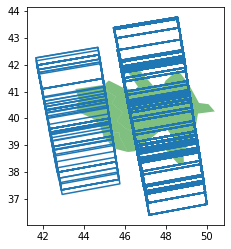

In [15]:
fig, ax = plt.subplots()
countries_with_missing_tiles.plot(ax=ax, alpha=.5, color='green')
df.exterior.plot(ax=ax)

In [10]:
gunw_ids = df['sceneName'].tolist()
gunw_ids[:10]

['S1-GUNW-A-R-072-tops-20141115_20141022-150151-00042E_00040N-PP-0323-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141129_20141012-144428-00047E_00037N-PP-76d1-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141129_20141012-144518-00046E_00040N-PP-e5c8-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141129_20141012-144543-00046E_00041N-PP-21e1-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141223_20141012-144427-00047E_00037N-PP-6faf-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141223_20141129-144427-00047E_00037N-PP-57d9-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141223_20141012-144452-00046E_00038N-PP-cbb3-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141223_20141129-144452-00046E_00038N-PP-e5fb-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141223_20141129-144517-00046E_00040N-PP-c465-v2_0_5',
 'S1-GUNW-A-R-101-tops-20141223_20141012-144542-00046E_00041N-PP-0942-v2_0_5']

In [11]:
with open("gunw_ids_with_missing_glo30_tiles.txt", "w") as f:
    f.write("\n".join(gunw_ids))